# Morning: Introduction to Time Series Analysis
The simplest demonstration of temporal dependence is seen by considering a univariate time series $y(t)$. In our case, $y(t)$ may be the surface-level atmsopheric concentration of ozone at a single EPA air-quality station in Orange County.

In [1]:
#-- Import Required Python Packages
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

#-- Import R packages in Python
r = robjects.r
nlme = importr('nlme')
stats = importr('stats')

## Is there a trend?

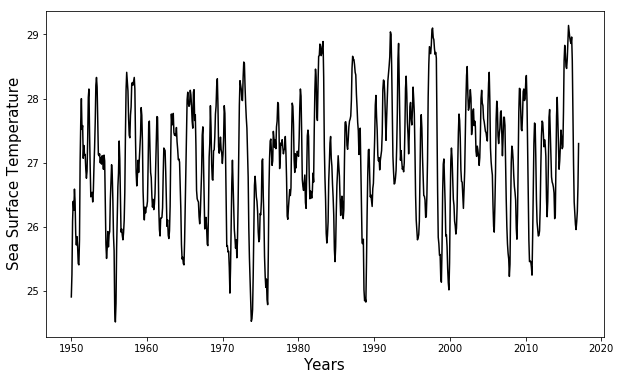

In [2]:
#-- Get El Nino data
sst = np.loadtxt('../Data/detrend.nino34.ascii.txt',skiprows=1)
y1 = sst[:,2]
t1 = np.linspace(1950,2017,len(y1))

#-- Plot time-series
fig = plt.figure(figsize=(10,6))
plt.plot(t1,y1,'k-')
plt.ylabel('Sea Surface Temperature',fontsize=15)
plt.xlabel('Years',fontsize=15)
plt.show()

In [3]:
#-- Linear fit:
#-- Convert Numpy arrays to R objects
robjects.globalenv["y1"] = robjects.FloatVector(y1)
robjects.globalenv["t1"] = robjects.FloatVector(t1)
#-- fit and display results
print r.summary(r.lm(r.formula("y1 ~ t1")))


Call:
(function (formula, data, subset, weights, na.action, method = "qr", 
    model = TRUE, x = FALSE, y = FALSE, qr = TRUE, singular.ok = TRUE, 
    contrasts = NULL, offset, ...) 
{
    ret.x <- x
    ret.y <- y
    cl <- match.call()
    mf <- match.call(expand.dots = FALSE)
    m <- match(c("formula", "data", "subset", "weights", "na.action", 
        "offset"), names(mf), 0L)
    mf <- mf[c(1L, m)]
    mf$drop.unused.levels <- TRUE
    mf[[1L]] <- quote(stats::model.frame)
    mf <- eval(mf, parent.frame())
    if (method == "model.frame") 
        return(mf)
    else if (method != "qr") 
        warning(gettextf("method = '%s' is not supported. Using 'qr'", 
            method), domain = NA)
    mt <- attr(mf, "terms")
    y <- model.response(mf, "numeric")
    w <- as.vector(model.weights(mf))
    if (!is.null(w) && !is.numeric(w)) 
        stop("'weights' must be a numeric vector")
    offset <- as.vector(model.offset(mf))
    if (!is.null(offset)) {
        if (length(offse

## Generate sample realizations

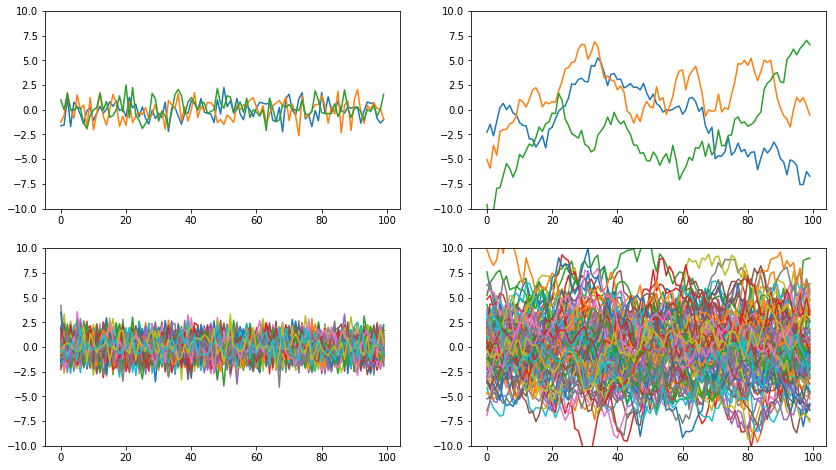

In [4]:
#-- Set up figure
fig, ax = plt.subplots(2,2,figsize=(14,8))

#-- 3 sample curves
for i in range(3):
    ax[0,0].plot(np.array(r.rnorm(100)))
    ax[0,1].plot(np.array(stats.arima_sim(100,model=robjects.ListVector({'ar':0.95}))))
    ax[0,0].set_ylim([-10,10])
    ax[0,1].set_ylim([-10,10])

#-- 100 sample curves
for i in range(100):
    ax[1,0].plot(np.array(r.rnorm(100)))
    ax[1,1].plot(np.array(stats.arima_sim(100,model=robjects.ListVector({'ar':0.95}))))
    ax[1,0].set_ylim([-10,10])
    ax[1,1].set_ylim([-10,10])

plt.show()

## The autocorrelation function

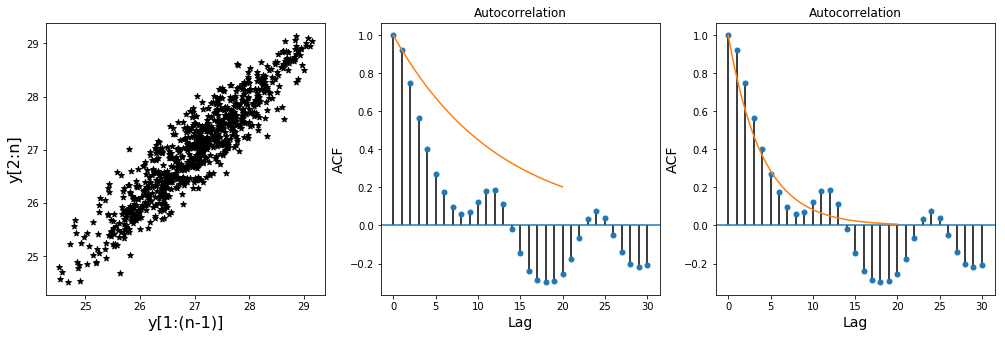

In [5]:
#-- Set up figure
fig, ax = plt.subplots(1,3,figsize=(17,5))
#-- Plot scatter plot of values shifted by 1
ax[0].scatter(y1[:-1],y1[1:],color='k',marker='*')
ax[0].set_xlabel('y[1:(n-1)]',fontsize=16)
ax[0].set_ylabel('y[2:n]',fontsize=16)
#-- plot autocorrelation
sm.graphics.tsa.plot_acf(y1,lags=30,alpha=np.float('nan'),ax=ax[1])
alpha_hat1 = np.corrcoef(y1[:-1],y1[1:])[0,1]
ax[1].plot(np.linspace(0,20),alpha_hat1**np.linspace(0,20))
ax[1].set_xlabel('Lag', fontsize=14)
ax[1].set_ylabel('ACF',fontsize=14)
sm.graphics.tsa.plot_acf(y1,lags=30,alpha=np.float('nan'),ax=ax[2])
ax[2].plot(np.linspace(0,20),0.78**np.linspace(0,20))
ax[2].set_xlabel('Lag', fontsize=14)
ax[2].set_ylabel('ACF',fontsize=14)
plt.show()

## Generate various time series structures

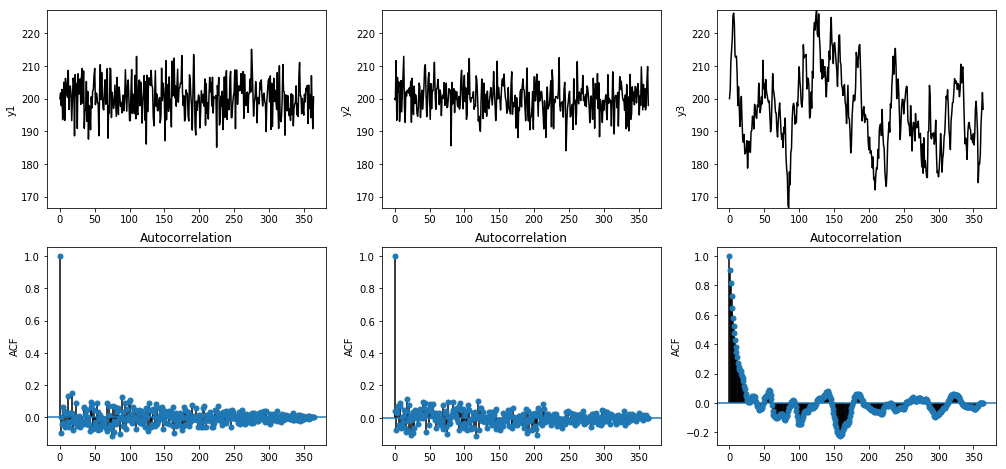

In [6]:
y0 = 20
a = 0.9
s = 5
b = 1
nyrs = 1
T = nyrs*365
f  = np.linspace(0,2*np.pi*nyrs,T)
sinf = np.sin(f)
y1= np.array([200])
y2 = np.copy(y1)
y3 = np.copy(y1)
for i in range(1,T):
    y1t1 = y1[0] + np.array(r.rnorm(1,0,s))
    y2t1 = y2[0] + np.array(r.rnorm(1,0,s)) + b*sinf[i]
    y3t1 = y0 + np.array(r.rnorm(1,0,s)) + b*sinf[i] + a*y3[i-1] 
    y1 = np.concatenate((y1,y1t1))
    y2 = np.concatenate((y2,y2t1))
    y3 = np.concatenate((y3,y3t1))
#-- Set up figure
fig, ax = plt.subplots(2,3,figsize=(17,8))
y_max = np.max([y1.max(),y2.max(),y3.max()])
y_min = np.min([y1.min(),y2.min(),y3.min()])
#-- Time-serires plots
for i,yi,lbl in zip(range(3),[y1,y2,y3],['y1','y2','y3']):
    ax[0,i].plot(yi,'k-')
    ax[0,i].set_ylim([y_min,y_max])
    ax[0,i].set_ylabel(lbl)
#-- ACF plots
for i,yi in zip(range(3),[y1,y2,y3]):
    sm.graphics.tsa.plot_acf(yi,lags=T-1,alpha=np.float('nan'),ax=ax[1,i])
    ax[1,i].set_ylabel('ACF')
plt.show()

## Simple trend analysis with autocorrelation

In [7]:
print r.summary(nlme.gls(r.formula("y1 ~ t1"), correlation=nlme.corAR1()))

Generalized least squares fit by REML
  Model: y1 ~ t1 
  Data: NULL 
       AIC      BIC    logLik
  637.1089 655.8723 -314.5545

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.9272067 

Coefficients:
               Value Std.Error   t-value p-value
(Intercept) 5.816964 16.795079 0.3463493  0.7292
t1          0.010672  0.008467 1.2603950  0.2079

 Correlation: 
   (Intr)
t1 -1    

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.4783251 -0.6540165  0.1030884  0.6908156  2.0707585 

Residual standard error: 0.9484359 
Degrees of freedom: 807 total; 805 residual



# MORNING BREAK

# Analysis of Orange Country ozone time series

# Simple trend analysis

In [8]:
#- Read Ozone data from CSV file
d = pd.read_csv('../Data/ozone_orange.csv')
#- Get ozone data except for 2016 
ind = np.nonzero(d['year']!=2016)
y2 = np.array(d['ozone'])[ind]
years = np.array(d['year'])[ind]
t2 = np.linspace(years.min(),years.max(),len(y2))

In [9]:
robjects.globalenv["y2"] = robjects.FloatVector(y2)
robjects.globalenv["t2"] = robjects.FloatVector(t2)
print r.summary(nlme.gls(r.formula("y2 ~ t2"), correlation=nlme.corAR1(),method='ML'))

Generalized least squares fit by maximum likelihood
  Model: y2 ~ t2 
  Data: NULL 
        AIC       BIC   logLik
  -21910.74 -21886.67 10959.37

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.8552849 

Coefficients:
                  Value Std.Error     t-value p-value
(Intercept)  0.03422281 0.6293315  0.05437963  0.9566
t2          -0.00000413 0.0003138 -0.01316690  0.9895

 Correlation: 
   (Intr)
t2 -1    

Standardized residuals:
         Min           Q1          Med           Q3          Max 
-2.056608887 -0.800994961  0.009574762  0.706174031  3.184672958 

Residual standard error: 0.01261744 
Degrees of freedom: 3035 total; 3033 residual



# Harmonic regression

In [10]:
#-- Get year interval
nyrs= years.max() - years.min()
f = np.linspace(0,2*np.pi*nyrs,len(y2))
sinf = np.sin(f)
cosf = np.cos(f)

In [11]:
robjects.globalenv["sinf"] = robjects.FloatVector(sinf)
robjects.globalenv["cosf"] = robjects.FloatVector(cosf)
print r.summary(nlme.gls(r.formula("y2 ~ sinf + cosf"), correlation=nlme.corAR1(),method='ML'))

Generalized least squares fit by maximum likelihood
  Model: y2 ~ sinf + cosf 
  Data: NULL 
        AIC       BIC   logLik
  -22053.52 -22023.43 11031.76

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.7700548 

Coefficients:
                  Value    Std.Error  t-value p-value
(Intercept) 0.025893952 0.0005036630 51.41126  0.0000
sinf        0.000891778 0.0007113883  1.25357  0.2101
cosf        0.010826465 0.0007096038 15.25706  0.0000

 Correlation: 
     (Intr) sinf  
sinf  0.000       
cosf -0.004  0.000

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.97903286 -0.72563451 -0.03934443  0.67355001  3.73500124 

Residual standard error: 0.0100069 
Degrees of freedom: 3035 total; 3032 residual



# Aliasing

# Time series decomposition

In [12]:
fit = nlme.gls(r.formula("y2 ~ sinf + cosf + t2"), correlation=nlme.corAR1(),method='ML')

In [13]:
k_hat = fit.rx2('coefficients')
print k_hat
k_hat_var = np.array(fit.rx2('varBeta'))
print k_hat_var
phi_hat = stats.coef(fit.rx2("modelStruct"),unconstrained=False)
e = np.array(fit.rx2('residuals'))

  (Intercept)          sinf          cosf            t2 
-8.728852e-03  8.972455e-04  1.082647e-02  1.726393e-05 

[[  1.51555016e-01  -2.39327705e-05  -1.27465230e-09  -7.55695647e-05]
 [ -2.39327705e-05   5.09997235e-07  -1.55858674e-19   1.19335679e-08]
 [ -1.27465230e-09  -1.55858674e-19   5.03681416e-07  -4.92254945e-19]
 [ -7.55695647e-05   1.19335679e-08  -4.92254945e-19   3.76811591e-08]]


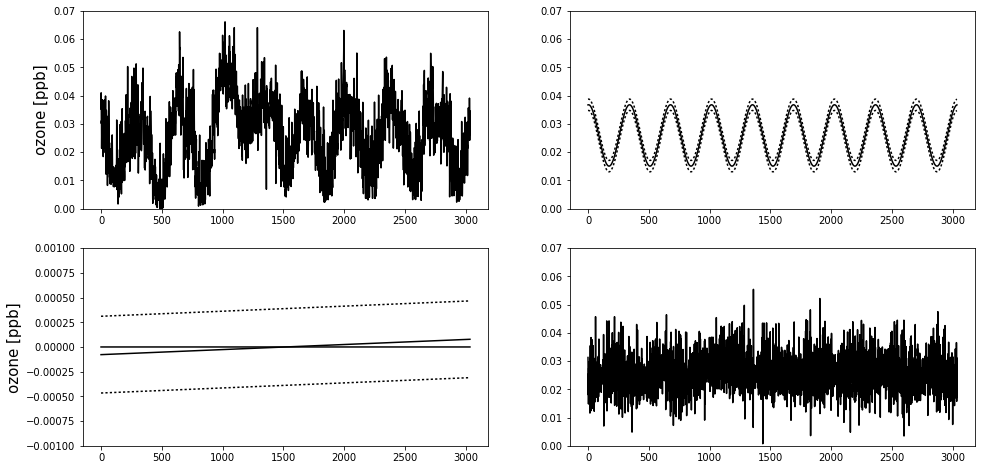

In [14]:
#-- Plot results
#-- Set up figure
fig, ax = plt.subplots(2,2,figsize=(16,8))
ax[0,0].plot(y2,'k-')
ax[0,0].set_ylim([0,0.07])
ax[0,0].set_ylabel('ozone [ppb]',fontsize=15)

f_hat = np.mean(y2) + k_hat[1]*sinf + k_hat[2]*cosf
ax[0,1].plot(f_hat,'k-')
ax[0,1].plot(f_hat + 2*np.sqrt(k_hat_var[1,1] + k_hat_var[2,2]),'k:') #-- note the variance is already std^2
ax[0,1].plot(f_hat - 2*np.sqrt(k_hat_var[1,1] + k_hat_var[2,2]),'k:')
ax[0,1].set_ylim([0,0.07])

t_hat = k_hat[0] + k_hat[3]*t2
t_hat -= np.mean(t_hat)
ax[1,0].plot(t_hat,'k-')
ax[1,0].plot(t_hat + 2*np.sqrt(k_hat_var[3,3]),'k:')
ax[1,0].plot(t_hat - 2*np.sqrt(k_hat_var[3,3]),'k:')
ax[1,0].plot(np.zeros(len(t_hat)),'k-')
ax[1,0].set_ylabel('ozone [ppb]',fontsize=15)
ax[1,0].set_ylim([-0.001,0.001])

ear = e[1:]-phi_hat*e[:-1]
ax[1,1].plot(np.mean(y2)+ear,'k-')
ax[1,1].set_ylim([0,0.07])
plt.show()

# Time series regression

In [15]:
#-- Get temperature, wind speed, and wind direction
x1 = np.array(d['temp'])[ind]
x2 = np.array(d['windsp'])[ind]
x3 = np.array(d['winddir'])[ind]
robjects.globalenv["x1"] = robjects.FloatVector(x1)
robjects.globalenv["x2"] = robjects.FloatVector(x2)
robjects.globalenv["x3"] = robjects.FloatVector(x3)

#-- fit model as a function of temperature and harmonics
fitx1 = nlme.gls(r.formula("y2 ~ sinf + cosf + x1"), correlation=nlme.corAR1(),method='ML')
print r.summary(fitx1)

Generalized least squares fit by maximum likelihood
  Model: y2 ~ sinf + cosf + x1 
  Data: NULL 
        AIC       BIC   logLik
  -22051.98 -22015.87 11031.99

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.7687963 

Coefficients:
                  Value    Std.Error   t-value p-value
(Intercept) 0.024437725 0.0021696121 11.263638  0.0000
sinf        0.000793210 0.0007218835  1.098807  0.2719
cosf        0.010728155 0.0007200955 14.898239  0.0000
x1          0.000022837 0.0000331050  0.689847  0.4903

 Correlation: 
     (Intr) sinf   cosf  
sinf  0.193              
cosf  0.192  0.039       
x1   -0.973 -0.198 -0.198

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.97991106 -0.72750894 -0.04116506  0.67466560  3.74885029 

Residual standard error: 0.009982415 
Degrees of freedom: 3035 total; 3031 residual



In [16]:
#-- fit model as a function of temperature and wind speed and direction and harmonics
fitx123 = nlme.gls(r.formula("y2 ~ sinf + cosf + x1 + x2 + x3"), correlation=nlme.corAR1(),method='ML')
print r.summary(fitx123)

Generalized least squares fit by maximum likelihood
  Model: y2 ~ sinf + cosf + x1 + x2 + x3 
  Data: NULL 
     AIC       BIC  logLik
  -22611 -22562.85 11313.5

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.7868927 

Coefficients:
                   Value    Std.Error   t-value p-value
(Intercept)  0.020406707 0.0021083140  9.679159  0.0000
sinf         0.001603743 0.0007131025  2.248965  0.0246
cosf         0.010199741 0.0007180072 14.205625  0.0000
x1          -0.000111914 0.0000307147 -3.643677  0.0003
x2           0.002810266 0.0001128399 24.904898  0.0000
x3           0.000016128 0.0000034484  4.676984  0.0000

 Correlation: 
     (Intr) sinf   cosf   x1     x2    
sinf  0.179                            
cosf  0.215  0.039                     
x1   -0.895 -0.189 -0.177              
x2   -0.087  0.044 -0.032 -0.166       
x3   -0.324 -0.037 -0.152 -0.012  0.190

Standardized residuals:
        Min          Q1         Med          Q3         Max 

# Model Selection

In [17]:
#-- make dictionary of models 
df = pd.DataFrame(data={
    'model':['fitx1','fitx123'],
    'R2':[(np.corrcoef(y2,r.predict(fitx1))[0,1])**2,(np.corrcoef(y2,r.predict(fitx123))[0,1])**2],
    'BIC':[np.squeeze(r.summary(fitx1).rx2('BIC')),np.squeeze(r.summary(fitx123).rx2('BIC'))],
    'k':[np.squeeze(r.summary(fitx1).rx2('dims').rx2('p')),np.squeeze(r.summary(fitx123).rx2('dims').rx2('p'))]}, 
                  columns=['model','R2','BIC','k'])
df

,model,R2,BIC,k
0,fitx1,0.374044,-22015.8735833,4
1,fitx123,0.442016,-22562.8512809,6


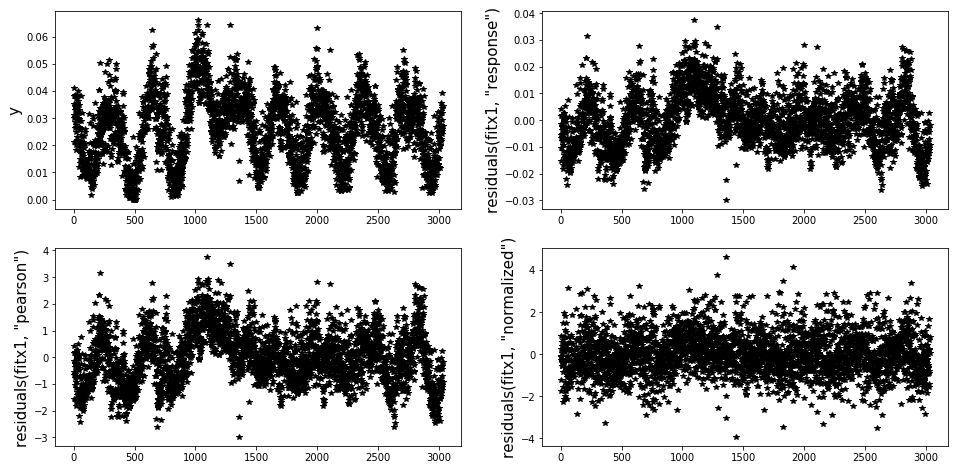

In [18]:
#plot
fig, ax = plt.subplots(2,2,figsize=(16,8))
ax[0,0].plot(y2,'k*')
ax[0,0].set_ylabel('y',fontsize=15)
ax[0,1].plot(r.residuals(fitx1, 'response'),'k*')
ax[0,1].set_ylabel('residuals(fitx1, "response")',fontsize=15)
ax[1,0].plot(r.residuals(fitx1, 'pearson'),'k*')
ax[1,0].set_ylabel('residuals(fitx1, "pearson")',fontsize=15)
ax[1,1].plot(r.residuals(fitx1, 'normalized'),'k*')
ax[1,1].set_ylabel('residuals(fitx1, "normalized")',fontsize=15)
plt.show()